## Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Hyperparameters

In [1]:
timesteps = 10
hidden_size = 32
input_size = 1
epochs = 100
learning_rate = 0.001
seed = 42

In [4]:
np.random.seed(seed)

## Load and preprocess data

In [5]:
def load_ecg_data(filename='ECG.xlsx'):
    data = pd.read_excel(filename, header=None)
    return data[0].values

In [6]:
def normalize_data(data):
    min_val, max_val = np.min(data), np.max(data)
    normalized = (data - min_val) / (max_val - min_val)
    return normalized, min_val, max_val

In [7]:
def denormalize_data(normalized, min_val, max_val):
    return normalized * (max_val - min_val) + min_val

In [8]:
def create_sequences(data, timesteps, forecast_horizon=2):
    X, y = [], []
    for i in range(len(data) - timesteps - forecast_horizon + 1):
        X.append(data[i:i + timesteps])
        y.append(data[i + timesteps + forecast_horizon - 1])
    return np.array(X), np.array(y)

## Activation functions

In [9]:
def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

In [10]:
def sigmoid_derivative(output):
    return output * (1 - output)

In [11]:
def tanh(x):
    return np.tanh(np.clip(x, -500, 500))

In [12]:
def tanh_derivative(output):
    return 1 - output ** 2

## Loss function

In [13]:
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [14]:
def mse_loss_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

## Model

### LSTM

In [15]:
class LSTMCell:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        limit = np.sqrt(6 / (hidden_size + input_size))

        # Forget gate
        self.Wf = np.random.uniform(-limit, limit, (hidden_size, hidden_size + input_size))
        self.bf = np.zeros(hidden_size)
        # Input gate
        self.Wi = np.random.uniform(-limit, limit, (hidden_size, hidden_size + input_size))
        self.bi = np.zeros(hidden_size)
        # Cell gate
        self.Wc = np.random.uniform(-limit, limit, (hidden_size, hidden_size + input_size))
        self.bc = np.zeros(hidden_size)
        # Output gate
        self.Wo = np.random.uniform(-limit, limit, (hidden_size, hidden_size + input_size))
        self.bo = np.zeros(hidden_size)

    def forward(self, x, h_prev, c_prev):
        self.x, self.h_prev, self.c_prev = x, h_prev, c_prev
        self.combined = np.hstack((h_prev, x))

        # Forget gate
        self.f = sigmoid(np.dot(self.Wf, self.combined) + self.bf)
        # Input gate
        self.i = sigmoid(np.dot(self.Wi, self.combined) + self.bi)
        # Cell gate
        self.c_tilde = tanh(np.dot(self.Wc, self.combined) + self.bc)
        # Cell state
        self.c = self.f * c_prev + self.i * self.c_tilde
        # Output gate
        self.o = sigmoid(np.dot(self.Wo, self.combined) + self.bo)
        # Hidden state
        self.h = self.o * tanh(self.c)
        return self.h, self.c

    def backward(self, dh_next, dc_next, learning_rate):
        # Gradient through output gate
        do = dh_next * tanh(self.c) * sigmoid_derivative(self.o)
        # Gradient through cell state
        dc = dh_next * self.o * tanh_derivative(self.c) + dc_next
        # Gradient through forget gate
        df = dc * self.c_prev * sigmoid_derivative(self.f)
        # Gradient through input gate
        di = dc * self.c_tilde * sigmoid_derivative(self.i)
        # Gradient through cell gate
        dc_tilde = dc * self.i * tanh_derivative(self.c_tilde)

        # Gradients for weights and biases
        dWf = np.dot(df.reshape(-1, 1), self.combined.reshape(1, -1))
        dWi = np.dot(di.reshape(-1, 1), self.combined.reshape(1, -1))
        dWc = np.dot(dc_tilde.reshape(-1, 1), self.combined.reshape(1, -1))
        dWo = np.dot(do.reshape(-1, 1), self.combined.reshape(1, -1))
        dbf, dbi, dbc, dbo = df, di, dc_tilde, do

        # Clip gradients
        clip_value = 1.0
        dWf = np.clip(dWf, -clip_value, clip_value)
        dWi = np.clip(dWi, -clip_value, clip_value)
        dWc = np.clip(dWc, -clip_value, clip_value)
        dWo = np.clip(dWo, -clip_value, clip_value)
        dbf = np.clip(dbf, -clip_value, clip_value)
        dbi = np.clip(dbi, -clip_value, clip_value)
        dbc = np.clip(dbc, -clip_value, clip_value)
        dbo = np.clip(dbo, -clip_value, clip_value)

        # Update weights and biases
        self.Wf -= learning_rate * dWf
        self.Wi -= learning_rate * dWi
        self.Wc -= learning_rate * dWc
        self.Wo -= learning_rate * dWo
        self.bf -= learning_rate * dbf
        self.bi -= learning_rate * dbi
        self.bc -= learning_rate * dbc
        self.bo -= learning_rate * dbo

        # Gradient for previous hidden and cell states
        dcombined = (np.dot(self.Wf.T, df) + np.dot(self.Wi.T, di) +
                     np.dot(self.Wc.T, dc_tilde) + np.dot(self.Wo.T, do))
        dh_prev = dcombined[:self.hidden_size]
        return dh_prev, dc * self.f

### GRU

In [16]:
class GRUCell:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        limit = np.sqrt(6 / (hidden_size + input_size))

        # Update gate
        self.Wz = np.random.uniform(-limit, limit, (hidden_size, hidden_size + input_size))
        self.bz = np.zeros(hidden_size)
        # Reset gate
        self.Wr = np.random.uniform(-limit, limit, (hidden_size, hidden_size + input_size))
        self.br = np.zeros(hidden_size)
        # Candidate hidden state
        self.Wh = np.random.uniform(-limit, limit, (hidden_size, hidden_size + input_size))
        self.bh = np.zeros(hidden_size)

    def forward(self, x, h_prev):
        self.x, self.h_prev = x, h_prev
        self.combined = np.hstack((h_prev, x))

        # Update gate
        self.z = sigmoid(np.dot(self.Wz, self.combined) + self.bz)
        # Reset gate
        self.r = sigmoid(np.dot(self.Wr, self.combined) + self.br)
        # Candidate hidden state
        self.combined_reset = np.hstack((self.r * h_prev, x))
        self.h_hat = tanh(np.dot(self.Wh, self.combined_reset) + self.bh)
        # Final hidden state
        self.h = (1 - self.z) * h_prev + self.z * self.h_hat
        return self.h

    def backward(self, dh, learning_rate):
        # Gradient through update gate
        dz = dh * (self.h_hat - self.h_prev) * sigmoid_derivative(self.z)
        # Gradient through candidate hidden state
        dh_hat = dh * self.z * tanh_derivative(self.h_hat)
        # Gradient through reset gate
        dcombined_reset = np.dot(self.Wh.T, dh_hat)
        dr = dcombined_reset[:self.hidden_size] * self.h_prev * sigmoid_derivative(self.r)

        # Gradients for weights and biases
        dWz = np.dot(dz.reshape(-1, 1), self.combined.reshape(1, -1))
        dWr = np.dot(dr.reshape(-1, 1), self.combined.reshape(1, -1))
        dWh = np.dot(dh_hat.reshape(-1, 1), self.combined_reset.reshape(1, -1))
        dbz, dbr, dbh = dz, dr, dh_hat

        # Clip gradients
        clip_value = 1.0
        dWz = np.clip(dWz, -clip_value, clip_value)
        dWr = np.clip(dWr, -clip_value, clip_value)
        dWh = np.clip(dWh, -clip_value, clip_value)
        dbz = np.clip(dbz, -clip_value, clip_value)
        dbr = np.clip(dbr, -clip_value, clip_value)
        dbh = np.clip(dbh, -clip_value, clip_value)

        # Update weights and biases
        self.Wz -= learning_rate * dWz
        self.Wr -= learning_rate * dWr
        self.Wh -= learning_rate * dWh
        self.bz -= learning_rate * dbz
        self.br -= learning_rate * dbr
        self.bh -= learning_rate * dbh

        # Gradient for previous hidden state
        dcombined_z = np.dot(self.Wz.T, dz)[:self.hidden_size]
        dcombined_r = np.dot(self.Wr.T, dr)[:self.hidden_size]
        dcombined_h = np.dot(self.Wh.T, dh_hat)[:self.hidden_size]
        dcombined = dcombined_z + dcombined_r + dcombined_h
        dh_prev = dcombined + dh * (1 - self.z)
        return dh_prev

### Dense

In [17]:
class DenseLayer:
    def __init__(self, input_size, output_size):
        limit = np.sqrt(6 / (input_size + output_size))
        self.W = np.random.uniform(-limit, limit, (output_size, input_size))
        self.b = np.zeros(output_size)

    def forward(self, x):
        self.x = x
        return np.dot(self.W, x) + self.b

    def backward(self, dL_dy, learning_rate):
        dW = np.dot(dL_dy.reshape(-1, 1), self.x.reshape(1, -1))
        db = dL_dy
        dL_dx = np.dot(self.W.T, dL_dy)

        # Clip gradients
        clip_value = 1.0
        dW = np.clip(dW, -clip_value, clip_value)
        db = np.clip(db, -clip_value, clip_value)

        # Update weights and biases
        self.W -= learning_rate * dW
        self.b -= learning_rate * db
        return dL_dx

### Ensemble

#### Version 1

In [26]:
class EnsembleModel1:
    def __init__(self, input_size, hidden_size, timesteps):
        self.lstm = [LSTMCell(input_size, hidden_size) for _ in range(timesteps)]
        self.gru = [GRUCell(input_size, hidden_size) for _ in range(timesteps)]
        self.dense = DenseLayer(hidden_size, 1)  # Input is summed LSTM and GRU outputs
        self.timesteps = timesteps
        self.hidden_size = hidden_size

    def forward(self, x_seq):
        h_lstm = np.zeros(self.hidden_size)
        c_lstm = np.zeros(self.hidden_size)
        h_gru = np.zeros(self.hidden_size)
        states_lstm = []
        states_gru = []

        # Process sequence through LSTM and GRU
        for t in range(self.timesteps):
            x_t = x_seq[t].reshape(-1)
            # LSTM forward
            h_lstm, c_lstm = self.lstm[t].forward(x_t, h_lstm, c_lstm)
            states_lstm.append((self.lstm[t].x, self.lstm[t].h_prev, self.lstm[t].c_prev,
                               self.lstm[t].combined, self.lstm[t].f, self.lstm[t].i,
                               self.lstm[t].c_tilde, self.lstm[t].c, self.lstm[t].o, self.lstm[t].h))
            # GRU forward
            h_gru = self.gru[t].forward(x_t, h_gru)
            states_gru.append((self.gru[t].x, self.gru[t].h_prev, self.gru[t].combined,
                              self.gru[t].z, self.gru[t].r, self.gru[t].combined_reset,
                              self.gru[t].h_hat, self.gru[t].h))

        # Combine LSTM and GRU outputs (sum)
        combined_output = h_lstm + h_gru
        # Dense layer
        y_pred = self.dense.forward(combined_output)
        return y_pred, states_lstm, states_gru

    def backward(self, dL_dy, states_lstm, states_gru, learning_rate):
        # Backprop through dense layer
        dL_dcombined = self.dense.backward(dL_dy, learning_rate)
        # Split gradient for LSTM and GRU (since outputs were summed)
        dL_dh_lstm = dL_dcombined
        dL_dh_gru = dL_dcombined

        # Backprop through LSTM
        dh_lstm = dL_dh_lstm
        dc_lstm = np.zeros(self.hidden_size)
        for t in reversed(range(self.timesteps)):
            self.lstm[t].x, self.lstm[t].h_prev, self.lstm[t].c_prev, self.lstm[t].combined, \
            self.lstm[t].f, self.lstm[t].i, self.lstm[t].c_tilde, self.lstm[t].c, \
            self.lstm[t].o, self.lstm[t].h = states_lstm[t]
            dh_lstm, dc_lstm = self.lstm[t].backward(dh_lstm, dc_lstm, learning_rate)

        # Backprop through GRU
        dh_gru = dL_dh_gru
        for t in reversed(range(self.timesteps)):
            self.gru[t].x, self.gru[t].h_prev, self.gru[t].combined, self.gru[t].z, \
            self.gru[t].r, self.gru[t].combined_reset, self.gru[t].h_hat, self.gru[t].h = states_gru[t]
            dh_gru = self.gru[t].backward(dh_gru, learning_rate)


#### Version 2

In [18]:
class EnsembleModel2:
    def __init__(self, input_size, hidden_size, timesteps):
        self.lstm = [LSTMCell(input_size, hidden_size) for _ in range(timesteps)]
        self.gru = [GRUCell(input_size, hidden_size) for _ in range(timesteps)]
        self.dense = DenseLayer(hidden_size * 2, 1)  # Input is concatenated LSTM and GRU outputs
        self.timesteps = timesteps
        self.hidden_size = hidden_size

    def forward(self, x_seq):
        h_lstm = np.zeros(self.hidden_size)
        c_lstm = np.zeros(self.hidden_size)
        h_gru = np.zeros(self.hidden_size)
        states_lstm = []
        states_gru = []

        # Process sequence through LSTM and GRU
        for t in range(self.timesteps):
            x_t = x_seq[t].reshape(-1)
            # LSTM forward
            h_lstm, c_lstm = self.lstm[t].forward(x_t, h_lstm, c_lstm)
            states_lstm.append((self.lstm[t].x, self.lstm[t].h_prev, self.lstm[t].c_prev,
                               self.lstm[t].combined, self.lstm[t].f, self.lstm[t].i,
                               self.lstm[t].c_tilde, self.lstm[t].c, self.lstm[t].o, self.lstm[t].h))
            # GRU forward
            h_gru = self.gru[t].forward(x_t, h_gru)
            states_gru.append((self.gru[t].x, self.gru[t].h_prev, self.gru[t].combined,
                              self.gru[t].z, self.gru[t].r, self.gru[t].combined_reset,
                              self.gru[t].h_hat, self.gru[t].h))

        # Combine LSTM and GRU outputs (concatenate)
        combined_output = np.concatenate([h_lstm, h_gru])
        # Dense layer
        y_pred = self.dense.forward(combined_output)
        return y_pred, states_lstm, states_gru

    def backward(self, dL_dy, states_lstm, states_gru, learning_rate):
        # Backprop through dense layer
        dL_dcombined = self.dense.backward(dL_dy, learning_rate)
        # Split gradient for LSTM and GRU (since outputs were concatenated)
        dL_dh_lstm = dL_dcombined[:self.hidden_size]
        dL_dh_gru = dL_dcombined[self.hidden_size:]

        # Backprop through LSTM
        dh_lstm = dL_dh_lstm
        dc_lstm = np.zeros(self.hidden_size)
        for t in reversed(range(self.timesteps)):
            self.lstm[t].x, self.lstm[t].h_prev, self.lstm[t].c_prev, self.lstm[t].combined, \
            self.lstm[t].f, self.lstm[t].i, self.lstm[t].c_tilde, self.lstm[t].c, \
            self.lstm[t].o, self.lstm[t].h = states_lstm[t]
            dh_lstm, dc_lstm = self.lstm[t].backward(dh_lstm, dc_lstm, learning_rate)

        # Backprop through GRU
        dh_gru = dL_dh_gru
        for t in reversed(range(self.timesteps)):
            self.gru[t].x, self.gru[t].h_prev, self.gru[t].combined, self.gru[t].z, \
            self.gru[t].r, self.gru[t].combined_reset, self.gru[t].h_hat, self.gru[t].h = states_gru[t]
            dh_gru = self.gru[t].backward(dh_gru, learning_rate)

### Training

In [19]:
def train_model(model, X_train, y_train, epochs, learning_rate):
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(len(X_train)):
            x_seq = X_train[i]
            y_true = y_train[i]

            # Forward pass
            y_pred, states_lstm, states_gru = model.forward(x_seq)
            loss = mse_loss(y_true, y_pred)
            epoch_loss += loss

            # Backward pass
            dL_dy = mse_loss_derivative(y_true, y_pred)
            model.backward(dL_dy, states_lstm, states_gru, learning_rate)

        avg_loss = epoch_loss / len(X_train)
        losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.6f}")
    return losses

### Prediction

In [20]:
def predict(model, X):
    predictions = []
    for i in range(len(X)):
        x_seq = X[i]
        y_pred, _, _ = model.forward(x_seq)
        predictions.append(y_pred[0])
    return np.array(predictions)

## Main

### Load dataset

In [21]:
data = load_ecg_data()

### Preprocess data

In [22]:
data_normalized, min_val, max_val = normalize_data(data)
X, y = create_sequences(data_normalized, timesteps, forecast_horizon=2)

### Train/Test split

In [23]:
train_size = int(0.8 * len(X))

In [24]:
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

### Version 01

#### Create Model

In [27]:
model = EnsembleModel1(input_size, hidden_size, timesteps)

#### Train Model

In [28]:
print("Training Ensemble Model...")
losses = train_model(model, X_train, y_train, epochs, learning_rate)

Training Ensemble Model...
Epoch 1/100, Loss: 0.011954
Epoch 2/100, Loss: 0.003822
Epoch 3/100, Loss: 0.002943
Epoch 4/100, Loss: 0.002460
Epoch 5/100, Loss: 0.002192
Epoch 6/100, Loss: 0.002040
Epoch 7/100, Loss: 0.001950
Epoch 8/100, Loss: 0.001892
Epoch 9/100, Loss: 0.001853
Epoch 10/100, Loss: 0.001824
Epoch 11/100, Loss: 0.001800
Epoch 12/100, Loss: 0.001779
Epoch 13/100, Loss: 0.001760
Epoch 14/100, Loss: 0.001742
Epoch 15/100, Loss: 0.001726
Epoch 16/100, Loss: 0.001709
Epoch 17/100, Loss: 0.001693
Epoch 18/100, Loss: 0.001678
Epoch 19/100, Loss: 0.001663
Epoch 20/100, Loss: 0.001648
Epoch 21/100, Loss: 0.001633
Epoch 22/100, Loss: 0.001618
Epoch 23/100, Loss: 0.001604
Epoch 24/100, Loss: 0.001590
Epoch 25/100, Loss: 0.001576
Epoch 26/100, Loss: 0.001562
Epoch 27/100, Loss: 0.001548
Epoch 28/100, Loss: 0.001534
Epoch 29/100, Loss: 0.001521
Epoch 30/100, Loss: 0.001508
Epoch 31/100, Loss: 0.001495
Epoch 32/100, Loss: 0.001482
Epoch 33/100, Loss: 0.001469
Epoch 34/100, Loss: 0.001

#### Result (Get prediction)

In [29]:
train_predictions = predict(model, X_train)
test_predictions = predict(model, X_test)

#### Denormalize predictions

In [30]:
train_predictions = denormalize_data(train_predictions, min_val, max_val)
test_predictions = denormalize_data(test_predictions, min_val, max_val)

In [31]:
y_train_denorm = denormalize_data(y_train, min_val, max_val)
y_test_denorm = denormalize_data(y_test, min_val, max_val)

#### Evaluate Model

In [32]:
train_mse = mse_loss(y_train_denorm, train_predictions)
test_mse = mse_loss(y_test_denorm, test_predictions)

In [33]:
print(f"Train MSE: {train_mse:.6f}")
print(f"Test MSE: {test_mse:.6f}")

Train MSE: 0.021166
Test MSE: 0.020959


#### Visualize Result

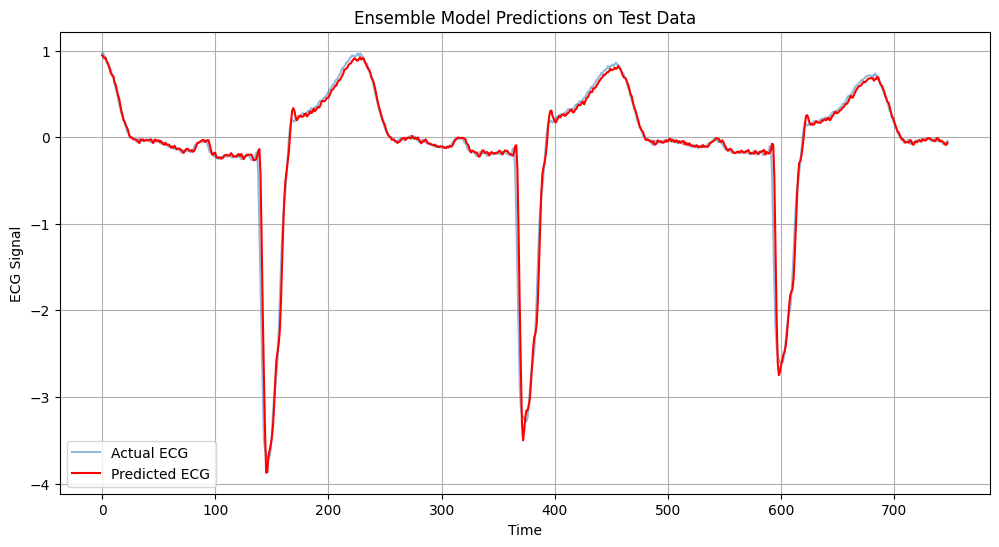

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_denorm, label='Actual ECG', alpha=0.5)
plt.plot(test_predictions, label='Predicted ECG', color='red')
plt.title('Ensemble Model Predictions on Test Data')
plt.xlabel('Time')
plt.ylabel('ECG Signal')
plt.legend()
plt.grid(True)
# plt.savefig('ensemble1_predictions.png')
plt.show()
plt.close()

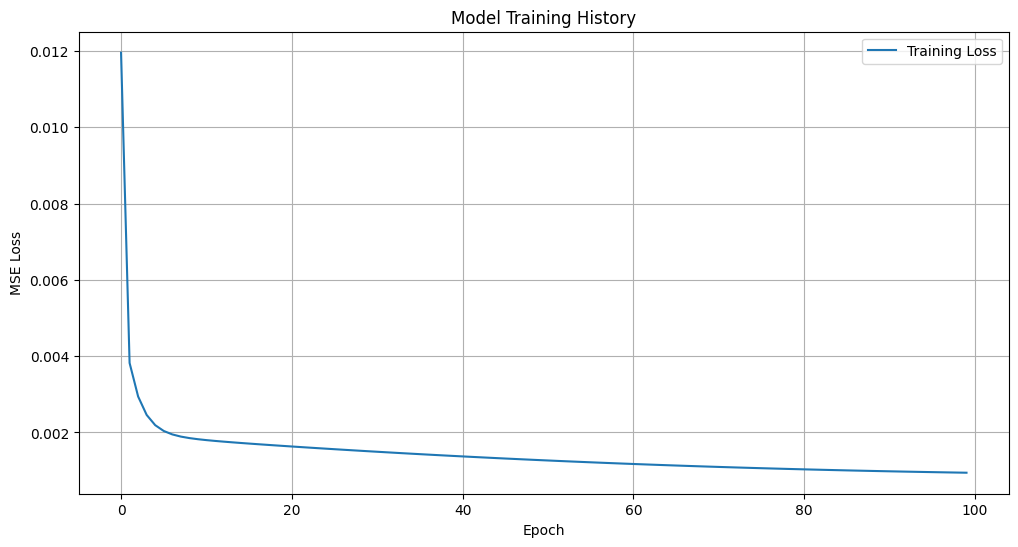

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(losses, label='Training Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
# plt.savefig('training1_history.png')
plt.show()
plt.close()

### Version 02

#### Create Model

In [36]:
model = EnsembleModel2(input_size, hidden_size, timesteps)

#### Train Model

In [37]:
print("Training Ensemble Model with Concatenation...")
losses = train_model(model, X_train, y_train, epochs, learning_rate)

Training Ensemble Model with Concatenation...
Epoch 1/100, Loss: 0.014389
Epoch 2/100, Loss: 0.005185
Epoch 3/100, Loss: 0.004409
Epoch 4/100, Loss: 0.003893
Epoch 5/100, Loss: 0.003550
Epoch 6/100, Loss: 0.003320
Epoch 7/100, Loss: 0.003163
Epoch 8/100, Loss: 0.003054
Epoch 9/100, Loss: 0.002975
Epoch 10/100, Loss: 0.002915
Epoch 11/100, Loss: 0.002869
Epoch 12/100, Loss: 0.002830
Epoch 13/100, Loss: 0.002797
Epoch 14/100, Loss: 0.002767
Epoch 15/100, Loss: 0.002740
Epoch 16/100, Loss: 0.002715
Epoch 17/100, Loss: 0.002691
Epoch 18/100, Loss: 0.002668
Epoch 19/100, Loss: 0.002645
Epoch 20/100, Loss: 0.002623
Epoch 21/100, Loss: 0.002602
Epoch 22/100, Loss: 0.002581
Epoch 23/100, Loss: 0.002560
Epoch 24/100, Loss: 0.002540
Epoch 25/100, Loss: 0.002520
Epoch 26/100, Loss: 0.002500
Epoch 27/100, Loss: 0.002481
Epoch 28/100, Loss: 0.002461
Epoch 29/100, Loss: 0.002442
Epoch 30/100, Loss: 0.002423
Epoch 31/100, Loss: 0.002405
Epoch 32/100, Loss: 0.002386
Epoch 33/100, Loss: 0.002368
Epoch 

#### Result (Get prediction)

In [38]:
train_predictions = predict(model, X_train)
test_predictions = predict(model, X_test)

#### Denormalize predictions

In [39]:
train_predictions = denormalize_data(train_predictions, min_val, max_val)
test_predictions = denormalize_data(test_predictions, min_val, max_val)

In [40]:
y_train_denorm = denormalize_data(y_train, min_val, max_val)
y_test_denorm = denormalize_data(y_test, min_val, max_val)

#### Evaluate Model

In [41]:
train_mse = mse_loss(y_train_denorm, train_predictions)
test_mse = mse_loss(y_test_denorm, test_predictions)

In [42]:
print(f"Train MSE: {train_mse:.6f}")
print(f"Test MSE: {test_mse:.6f}")

Train MSE: 0.031931
Test MSE: 0.031171


#### Visualize Result

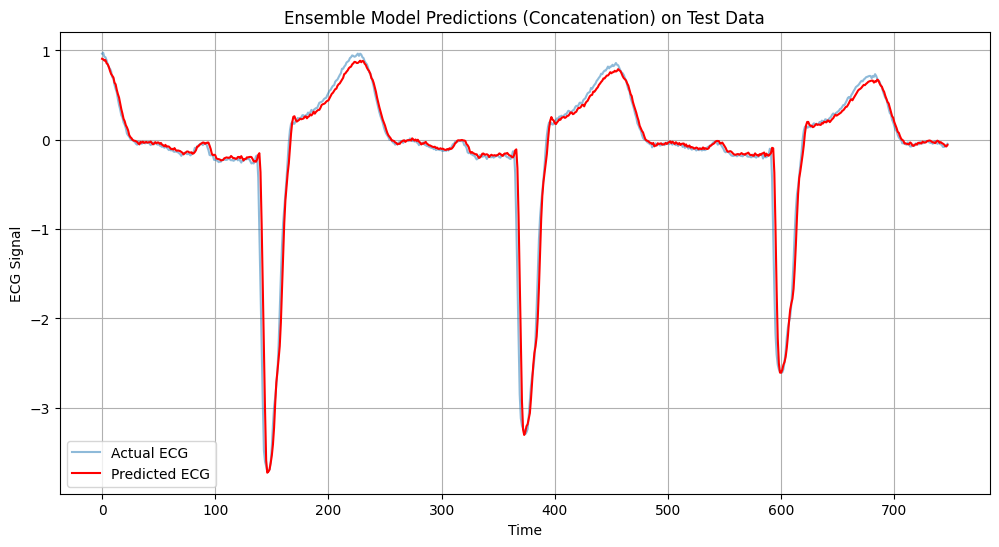

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_denorm, label='Actual ECG', alpha=0.5)
plt.plot(test_predictions, label='Predicted ECG', color='red')
plt.title('Ensemble Model Predictions (Concatenation) on Test Data')
plt.xlabel('Time')
plt.ylabel('ECG Signal')
plt.legend()
plt.grid(True)
# plt.savefig('ensemble2_predictions_concat.png')
plt.show()
plt.close()

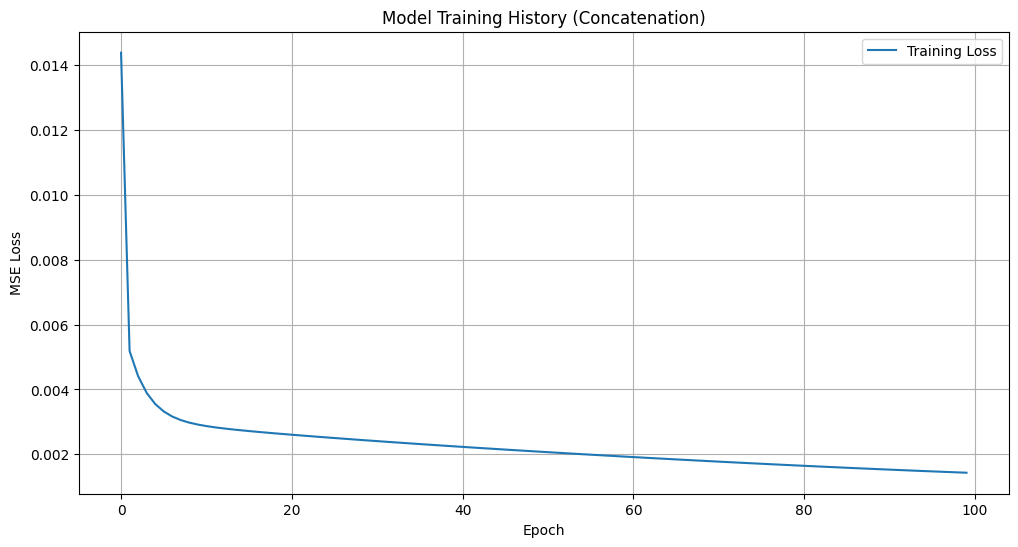

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(losses, label='Training Loss')
plt.title('Model Training History (Concatenation)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
# plt.savefig('training2_history_concat.png')
plt.show()
plt.close()